# Week 02 - Deep Learning Repetition

## Basic Model

In the first notebook the goal is to build a basic **feed-forward neural network**. As a dataset, the MNIST hand-drawn digits images are used. This is a common dataset that allows exploring different concepts without too much overhead.

Without further ado, let's get started! 😄

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm.notebook import tqdm
from pathlib import Path
import shutil
import onnxruntime

device = "cuda" if torch.cuda.is_available() else "cpu"

device = "cpu"
print(f"Using {device.upper()}")

Using CPU


## Load the MNIST Dataset

Using the `dataset.MNIST` function allows to automatically create a train and test dataset by setting the parameter `train` to either `True` or `False`

In [2]:
# Convert data to tensor
image_transformation = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [3]:
mnist_directory = Path.cwd() / ".mnist_data" / "0_basic"

# Delete the existing MNIST data directory if it exists
if mnist_directory.exists() and mnist_directory.is_dir():
    shutil.rmtree(mnist_directory)

In [4]:
# Load the MNIST dataset
dataset_mnist_train = datasets.MNIST(
    mnist_directory, train=True, download=True, transform=image_transformation
)
dataset_mnist_test = datasets.MNIST(
    mnist_directory, train=False, download=True, transform=image_transformation
)

100%|██████████| 9.91M/9.91M [00:20<00:00, 484kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 145kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 342kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Split the training dataset into training and validation sets using PyTorch's `random_split` function.

In [5]:
train_size = int(0.8 * len(dataset_mnist_train))
val_size = len(dataset_mnist_train) - train_size
dataset_mnist_train, dataset_mnist_val = random_split(
    dataset_mnist_train, [train_size, val_size]
)

The `DataLoader` class is useful to create batch sizes of the data and to shuffle it.

In [6]:
train_loader = DataLoader(dataset_mnist_train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_mnist_val, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_mnist_test, batch_size=64, shuffle=True)

## Visualize the Dataset

Let us briefly look at the data 👀

In [7]:
images, labels = next(iter(train_loader))

print(f"Image Batch shape: {images.shape}")
print(f"Label Batch shape: {labels.shape}")

# Cheack on which device the data is
print(f"Image Batch device: {images.device}")
print(f"Label Batch device: {labels.device}")

Image Batch shape: torch.Size([64, 1, 28, 28])
Label Batch shape: torch.Size([64])
Image Batch device: cpu
Label Batch device: cpu


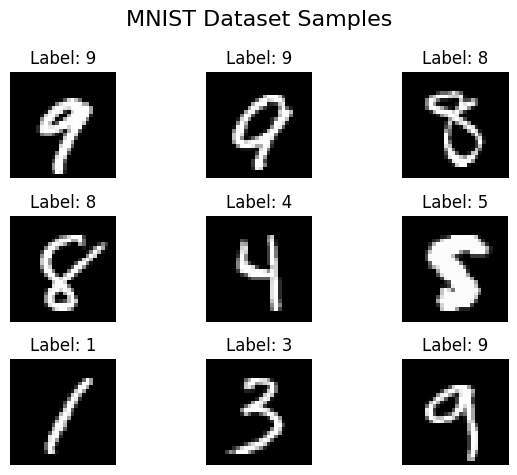

In [8]:
fig, axes = plt.subplots(3, 3)
fig.suptitle("MNIST Dataset Samples", fontsize=16)

for ax in axes.flat:
    idx = torch.randint(0, len(images), (1,))
    ax.imshow(images[idx].squeeze(), cmap="gray")
    ax.set_title(f"Label: {labels[idx].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Model Architecture

We use a very simple feed-forward neural network. This is of course not ideal yet, but it is to demonstrate that it can work quite well for such a simple task.

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Flatten(start_dim=1),
    torch.nn.Linear(in_features=28 * 28, out_features=128),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=128, out_features=128),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=128, out_features=10),
)
model = model.to(device)

# Check on which device the model is
print(f"Model device: {next(model.parameters()).device}")

Model device: cpu


In [10]:
print(summary(model=model, input_size=images.shape,device=device))

model_output = model(images)
print(f"Model output shape: {model_output.shape}")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Flatten: 1-1                           [64, 784]                 --
├─Linear: 1-2                            [64, 128]                 100,480
├─ReLU: 1-3                              [64, 128]                 --
├─Linear: 1-4                            [64, 128]                 16,512
├─ReLU: 1-5                              [64, 128]                 --
├─Linear: 1-6                            [64, 10]                  1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.57
Input size (MB): 0.20
Forward/backward pass size (MB): 0.14
Params size (MB): 0.47
Estimated Total Size (MB): 0.81
Model output shape: torch.Size([64, 10])


## Model Training

Training Epoch 1/2:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.9870


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.4131
After batch 200: Train Loss: 0.6695


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.3179
After batch 300: Train Loss: 0.5484


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.3173
After batch 400: Train Loss: 0.4823


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.2479
After batch 500: Train Loss: 0.4342


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.2233
After batch 600: Train Loss: 0.4000


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.2198
After batch 700: Train Loss: 0.3731


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.1917
Epoch 1 - Train Loss: 0.3593


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 0.1772


Training Epoch 2/2:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.1604


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.1695
After batch 200: Train Loss: 0.1661


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.1622
After batch 300: Train Loss: 0.1620


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.1617
After batch 400: Train Loss: 0.1583


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.1421
After batch 500: Train Loss: 0.1535


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.1377
After batch 600: Train Loss: 0.1504


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.1405
After batch 700: Train Loss: 0.1482


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.1202
Epoch 2 - Train Loss: 0.1459


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 - Validation Loss: 0.1368


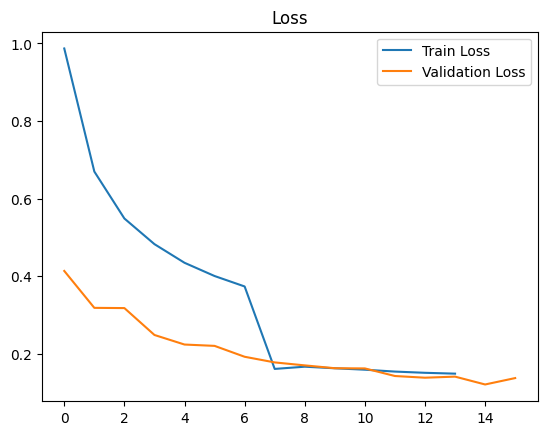

In [ ]:
EPOCHS = 2
LEARNING_RATE = 0.001
BATCH_INTERVAL = 100  # Calculate losses after every 100 batches

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()  # Inplicitly applies a softmax activation to the model logits

train_loss_history = []
val_loss_history = []

model.to(device)

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    for batch_idx, (image_batch, output_batch) in enumerate(
        tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"), start=1
    ):
        image_batch, output_batch = image_batch.to(device), output_batch.to(device)
        optimizer.zero_grad()
        model_output = model(image_batch)
        loss = loss_function(model_output, output_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        if (batch_idx) % BATCH_INTERVAL == 0:
            avg_train_loss = running_train_loss / (batch_idx)
            train_loss_history.append(avg_train_loss)
            print(f"After batch {batch_idx}: Train Loss: {avg_train_loss:.4f}")

            # Evaluate validation loss
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for val_image_batch, val_output_batch in tqdm(
                    val_loader, desc="Validation"
                ):
                    val_image_batch, val_output_batch = (
                        val_image_batch.to(device),
                        val_output_batch.to(device),
                    )
                    val_model_output = model(val_image_batch)
                    val_loss = loss_function(val_model_output, val_output_batch)
                    running_val_loss += val_loss.item()
            avg_val_loss = running_val_loss / len(val_loader)
            val_loss_history.append(avg_val_loss)
            print(f"After batch {batch_idx}: Validation Loss: {avg_val_loss:.4f}")
            model.train()  # Switch back to training mode

    avg_epoch_train_loss = running_train_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Train Loss: {avg_epoch_train_loss:.4f}")

    # Evaluate validation loss at the end of each epoch
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_image_batch, val_output_batch in tqdm(val_loader, desc="Validation"):
            val_model_output = model(val_image_batch)
            val_loss = loss_function(val_model_output, val_output_batch)
            running_val_loss += val_loss.item()
    avg_epoch_val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(avg_epoch_val_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_epoch_val_loss:.4f}")

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.title("Loss")
plt.legend()
plt.show()

## Test the Model

Test the freshly trained model with a randomly drawn image from the dataset.

In [ ]:
def load_onnx_model(path_to_model: Path):
    if path_to_model is None:
        raise ValueError("Path must be provided to load the ONNX model.")
    return onnxruntime.InferenceSession(
        str(path_to_model), providers=["CPUExecutionProvider"]
    )


def predict_digit(
    input_tensor: torch.Tensor,
    model: torch.nn.Module = None,
    onnx: bool = False,
    onnx_model_path: Path = None,
) -> tuple[int, float]:
    if onnx:
        model_session = load_onnx_model(onnx_model_path)
        onnx_predictions = model_session.run(None, {"image": input_tensor})
        predictions = torch.tensor(np.array(onnx_predictions))
    else:
        predictions = model(input_tensor)

    predicted_number = torch.argmax(predictions)
    probabilities = F.softmax(predictions.clone().detach(), dim=-1).numpy().squeeze()
    confidence = probabilities[predicted_number]
    return predicted_number.item(), confidence

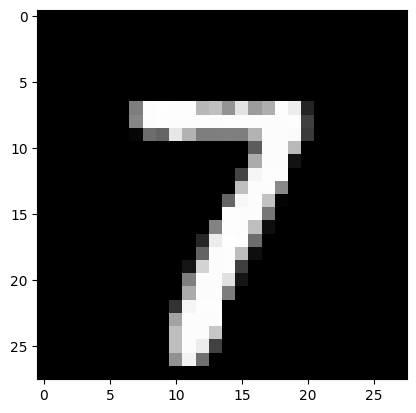

Predicted : 7 - Confidence: 99.77%
True label: 7


In [13]:
sampling_idx = torch.randint(0, len(images), (1,))
test_img = images[sampling_idx]
test_label = labels[sampling_idx]
plt.imshow(test_img.numpy().squeeze(), cmap="grey")
plt.show()
predicted_number, confidence = predict_digit(test_img, model)
print(f"Predicted : {predicted_number} - Confidence: {100*confidence:.2f}%")
print(f"True label: {test_label.item()}")

### Metrics

Does it look good?

Since this is just one image from the **training** dataset, we need to evaluate how the model performs on data it has never seen before. This is where the **test** dataset comes in. In the following cell, we calculate various metrics to evaluate the model's performance.

The metrics we will calculate are Accuracy, Recall, F1 score, and Support:

- **Accuracy**: The ratio of correctly predicted instances to the total instances. It gives an overall measure of how well the model is performing.
- **Recall**: The ratio of correctly predicted positive observations to all the observations in the actual class. It says how likely the model is to find all the relevant cases (true positives). It is important when the cost of false negatives is high.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. It indicates how many of the predicted positive cases were actually positive. It is important when the cost of false positives is high.
- **F1 Score**: The weighted average of Precision and Recall. It is useful when you need a balance between Precision and Recall.
- **Support**: The number of actual occurrences of the class in the dataset. It helps in understanding the distribution of the dataset.

When interpreting these metrics, keep in mind:
- **Accuracy** can be misleading if the dataset is imbalanced.
- **Recall** is important when the cost of false negatives is high.
- **Precision** is important when the cost of false positives is high.
- **F1 Score** is useful when you need to balance Precision and Recall.
- **Support** helps in understanding the context of the other metrics.


Evaluating the model on the Test set:   0%|          | 0/157 [00:00<?, ?it/s]

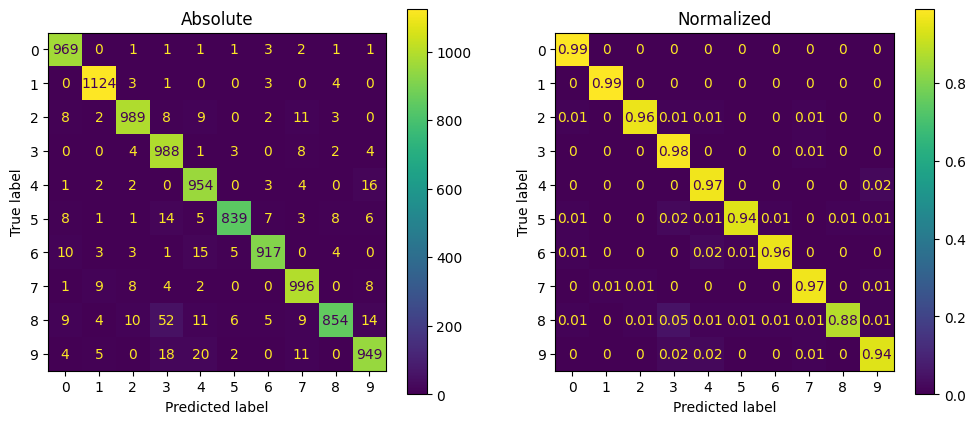

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.91      0.98      0.94      1010
           4       0.94      0.97      0.95       982
           5       0.98      0.94      0.96       892
           6       0.98      0.96      0.97       958
           7       0.95      0.97      0.96      1028
           8       0.97      0.88      0.92       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [14]:
model.to(device)
model.eval()

test_predicted_output = []
test_true_output = []

with torch.no_grad():
    for batch_idx, (image_batch, output_batch) in enumerate(
        tqdm(test_loader, desc="Evaluating the model on the Test set")
    ):
        image_batch, output_batch = image_batch.to(device), output_batch.to(device)
        model_output = model(image_batch)
        predicted_numbers = torch.argmax(model_output, dim=1)
        test_predicted_output.extend(predicted_numbers.cpu().numpy())
        test_true_output.extend(output_batch.cpu().numpy())

cm_abs = confusion_matrix(
    test_true_output, test_predicted_output, labels=[i for i in range(10)]
)
cm_norm = confusion_matrix(
    test_true_output,
    test_predicted_output,
    labels=[i for i in range(10)],
    normalize="true",
)
cm_round = np.around(cm_norm, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

disp_abs = ConfusionMatrixDisplay(
    confusion_matrix=cm_abs, display_labels=[i for i in range(10)]
)
disp_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_round, display_labels=[i for i in range(10)]
)

classification_report_test = classification_report(
    test_true_output, test_predicted_output, labels=[i for i in range(10)]
)

disp_abs.plot(ax=ax1)
ax1.set_title("Absolute")
ax1.grid(False)

disp_norm.plot(ax=ax2)
ax2.set_title("Normalized")
ax2.grid(False)
plt.show()

print(classification_report_test)

The metrics look quite solid, so let's move on!

## Model Export

In [15]:
FILE_NAME = "./0_basic_mnist_model.onnx"

MODEL_FOLDER = Path.cwd() / "models"
MODEL_PATH = MODEL_FOLDER / FILE_NAME

# Create the directory if it doesn't exist
if not MODEL_FOLDER.exists():
    MODEL_FOLDER.mkdir(parents=True, exist_ok=True)
    print(f"Directory '{MODEL_FOLDER}' created.")
else:
    print(f"Directory '{MODEL_FOLDER}' already exists.")

Directory 'c:\Users\TobiasRothlin\Documents\Python_Projects\ComputerVisionTurtorial\models' already exists.


In [16]:
# Save the model
model.eval()
image = images[0].unsqueeze(0)
torch.onnx.export(
    model, image, MODEL_PATH, input_names=["image"], output_names=["digit"]
)

print(f"Model exported in ONNX format to: {MODEL_PATH}")

Model exported in ONNX format to: c:\Users\TobiasRothlin\Documents\Python_Projects\ComputerVisionTurtorial\models\0_basic_mnist_model.onnx


## Real-world Data

Most tutorials would just finish with the above evaluation. After all, the metrics look quite good, the majority of the manually provided samples to the model are correctly classified; what more do you want?

What is mostly missing, but what is the most common problem in practice, is, that there are real-world cases with real-world data. The model is performing quite well, but what if you provide completely novel hand-written digits to it that is maybe not nicely centred, or is drawn with a different pencil width, or rotated, etc.

In the following section, we add this real-world scenario by letting you draw your own hand-written digits and test your trained models against this custom dataset.

### Single Digit

To create a single digit that can be run in the `Real-World Model Inference` below:
1. Open the drawing tool to create hand-written digits yourself by running the next cell
1. Select the model you just created
1. Draw a digit
1. Click on 'Classify' to see how well the model predicts
1. Close the tool (or try more digits)

#### Custom Digits Test Dataset

To create a suite of digits ranging from 0 to 9 that can be run in the `Real-World Digits Comparison` below:
1. Open the drawing tool to create hand-written digits yourself by running the next cell
1. Click on `Create Custom Test Set`
1. Draw the digit that is prompted
1. Click on `Save and Next`
1. Once done you can change any drawn number by selecting it from the dropdown

In [17]:
!python src/model_test_drawing.py

Predicted number: 6, Confidence: 0.9951


### Real-World Model Inference

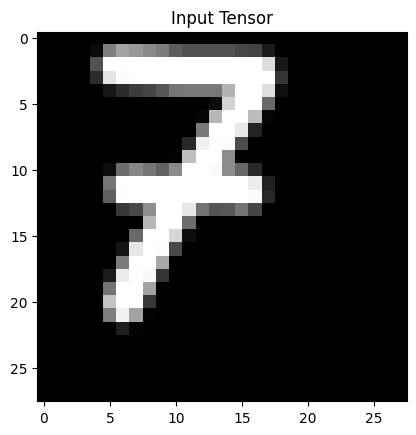

PyTorch model prediction: 6 - Confidence: 99.51%
ONNX model prediction:    6 - Confidence: 99.51%


In [18]:
assert (
    Path.cwd() / "handwriting" / "my_digit.npy"
).exists(), "Draw and classify a digit first."
image_input_tensor = np.load("handwriting/my_digit.npy")

plt.cla()
plt.imshow(image_input_tensor[0].squeeze(), cmap="grey")
plt.title("Input Tensor")
plt.show()

try:
    model.eval()
    pt_predicted_number, pt_confidence = predict_digit(
        torch.tensor(image_input_tensor), model
    )
    print(
        f"PyTorch model prediction: {pt_predicted_number} - Confidence: {100*pt_confidence:.2f}%"
    )
except NameError:
    print("PyTorch: no model present, skipping...")

onnx_predicted_number, onnx_confidence = predict_digit(
    image_input_tensor, onnx=True, onnx_model_path=MODEL_PATH
)
print(
    f"ONNX model prediction:    {onnx_predicted_number} - Confidence: {100*onnx_confidence:.2f}%"
)

#### Real-World Digits Comparison

The plot lets you compare the performance of all the models from the following notebooks (they will have the same output, just with their model).

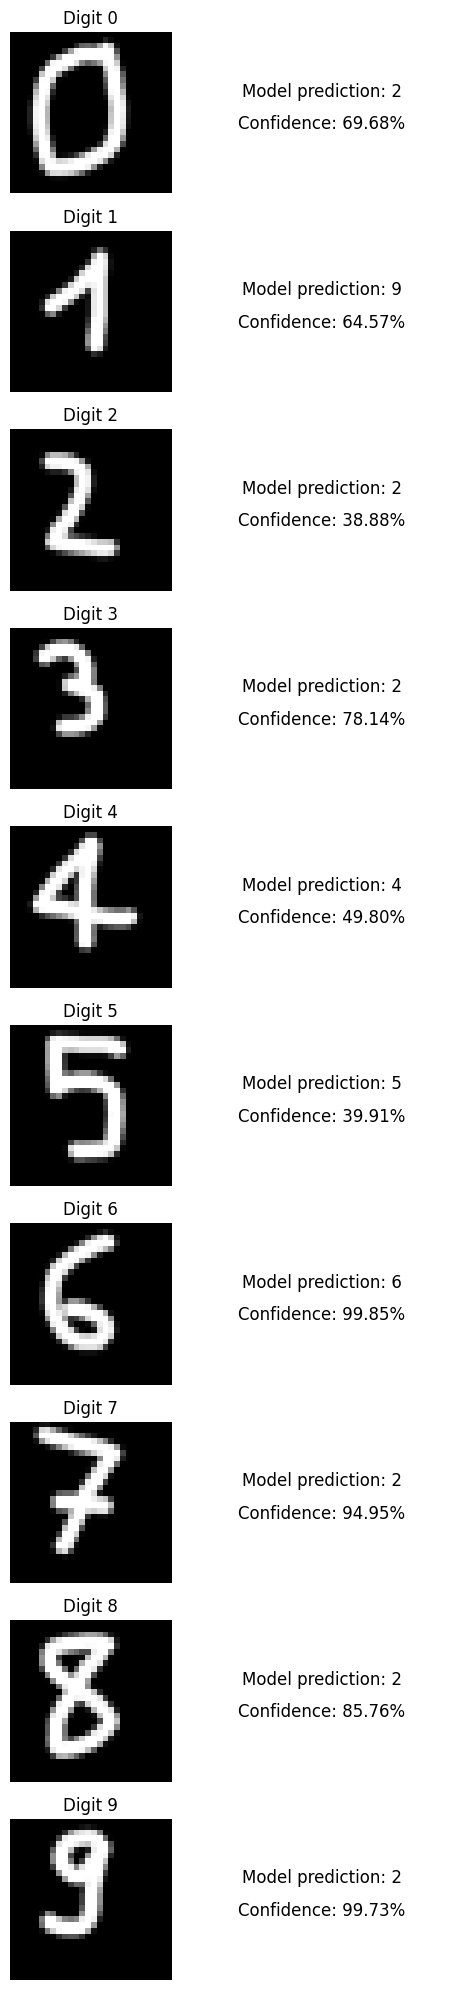

In [19]:
assert (
    Path.cwd() / "handwriting" / "digit_0.npy"
).exists(), "Draw and classify a digit first."
directory_path = Path("handwriting/")

fig, axes = plt.subplots(10, 2, figsize=(5, 20))

for i in range(10):
    file_path = directory_path / f"digit_{i}.npy"
    image_input_tensor = np.load(file_path)

    axes[i, 0].imshow(image_input_tensor.squeeze(), cmap="gray")
    axes[i, 0].set_title(f"Digit {i}")
    axes[i, 0].axis("off")

    onnx_predicted_number, onnx_confidence = predict_digit(
        image_input_tensor, onnx=True, onnx_model_path=MODEL_PATH
    )

    axes[i, 1].text(
        0.5, 0.6, f"Model prediction: {onnx_predicted_number}", fontsize=12, ha="center"
    )
    axes[i, 1].text(
        0.5, 0.4, f"Confidence: {100*onnx_confidence:.2f}%", fontsize=12, ha="center"
    )
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

The model is probably wrong in its predictions on your handwritten digits.

What may be noticeable, is that the model is wrong, but has a relatively high confidence in its prediction. Usually not something that we want!

Let's address this problem in the next notebook.